In [1]:
import torch
import cloudy

pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()

Downloading...
From (original): https://drive.google.com/uc?id=1UTf-S8sM6m8t5IuCsbyvdZuuFs7cs9LE
From (redirected): https://drive.google.com/uc?id=1UTf-S8sM6m8t5IuCsbyvdZuuFs7cs9LE&confirm=t&uuid=f9c96140-84b8-4e45-a677-3d4b24877e05
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 292M/292M [00:02<00:00, 111MB/s]  


In [2]:
latent = pipeline.generate_latent(steps_rate=20)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Unconditional sampling DDIM: 100%|██████████| 50/50 [00:01<00:00, 46.54it/s]


In [15]:
with torch.no_grad():
    rep = pipeline.from_latent_to_rep(latent)
    grid = pipeline.from_rep_to_grid(rep, 256)
    grid = grid * (grid >= 0.01).float()

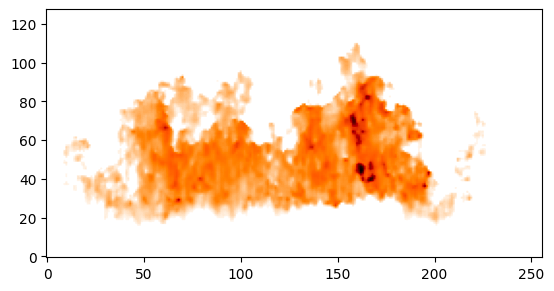

In [16]:
import matplotlib.pyplot as plt

plt.imshow(grid[:, :, grid.shape[2]//2, 0].cpu().T, cmap='gist_heat_r')
plt.gca().invert_yaxis()
plt.show()

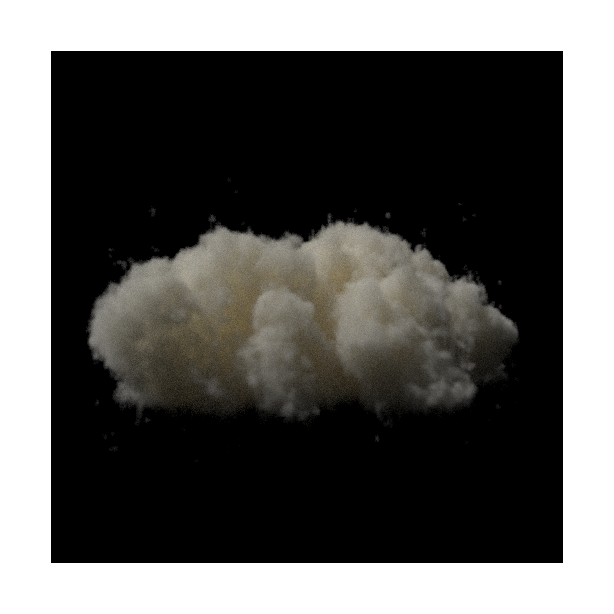

In [17]:
with torch.no_grad():
    camera_poses = cloudy.camera_poses((2.7, 0.0, 0.0))
    environment = torch.zeros(64, 128, 3, device='cuda')
    environment[10,0] = 1600
    im = cloudy.scattered(grid * 300, 
                          camera_poses=camera_poses,
                          scattering_albedo=(0.99, 0.98, 0.94),
                          environment=environment,
                          phase_g=0.0,
                          majorant=grid.max()*300,
                          # kwargs
                          width=512, 
                          height=512,
                          jittered=True,
                          samples=128
                          )
    plt.figure(figsize=(1, 1), dpi=512)
    plt.imshow(im[0].cpu() ** (1.0/2.2))
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.tight_layout(pad=0.0)
    plt.show()

In [6]:
import numpy as np
from tqdm import tqdm

with torch.no_grad():
    frames = torch.zeros(100, 512, 512, 3)
    for f in tqdm(range(len(frames)), desc="Generating video"):
        alpha = f/(len(frames) - 1)
        camera_poses = cloudy.camera_poses((np.cos(alpha*6.28)*2.7, np.sin(alpha*6.28), np.sin(alpha*6.28)*2.7))
        im = cloudy.scattered(grid * 300, 
                          camera_poses=camera_poses,
                          scattering_albedo=(0.99, 0.98, 0.94),
                          environment=environment,
                          phase_g=0.0,
                          majorant=grid.max()*300,
                          # kwargs
                          width=512, 
                          height=512,
                          jittered=True,
                          samples=128
                          )[0]
        frames[f] = torch.flip(im, dims=[0])
    cloudy.save_video(frames, 'generated_cloud.webp')

Generating video: 100%|██████████| 100/100 [07:53<00:00,  4.73s/it]


In [7]:
import moviepy.editor
moviepy.editor.ipython_display("generated_cloud.webp", filetype='image')

ModuleNotFoundError: No module named 'moviepy.editor'

In [ ]:
!pip list | grep moviepy